### Imports and Data Loading

In [1]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_predict
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import concurrent.futures
import numpy as np
import matplotlib.pyplot as plt
import shap

In [2]:
# Load the dataset
file_path = 'final_patients_dataset.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8677 entries, 0 to 8676
Data columns (total 81 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   subject_id                             8677 non-null   int64  
 1   pneumonia_hadm_id                      8677 non-null   int64  
 2   pneumonia_admittime                    8677 non-null   object 
 3   pneumonia_icd_codes                    8677 non-null   object 
 4   has_heart_failure                      8677 non-null   bool   
 5   heart_failure_hadm_id                  3097 non-null   float64
 6   heart_failure_admittime                3097 non-null   object 
 7   heart_failure_icd_codes                3097 non-null   object 
 8   hadm_ids_within_6_months               8677 non-null   object 
 9   hadm_ids_everything_till_6_months      8677 non-null   object 
 10  hadm_ids_everything_list               8677 non-null   object 
 11  Hype

,subject_id,pneumonia_hadm_id,pneumonia_admittime,pneumonia_icd_codes,has_heart_failure,heart_failure_hadm_id,heart_failure_admittime,heart_failure_icd_codes,hadm_ids_within_6_months,hadm_ids_everything_till_6_months,...,O2 Saturation Pulseoxymetry_max,O2 Saturation Pulseoxymetry_avg,Temperature Fahrenheit_min,Temperature Fahrenheit_max,Temperature Fahrenheit_avg,Oxygen Saturation_min,Oxygen Saturation_max,Oxygen Saturation_avg,gender,age
0,10000826,20032235,2146-12-05 19:07:00,486,False,NaN,NaN,NaN,"21086876, 28289260","20032235, 21086876, 28289260",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,32
1,10002155,23822395,2129-08-04 12:44:00,486,False,NaN,NaN,NaN,28976727,"28439444, 23822395, 28976727",...,99.0,92.911950,95.9,98.8,97.430556,NaN,NaN,NaN,0,81
2,10002155,28994087,2130-09-23 21:59:00,486,False,NaN,NaN,NaN,20345487,"28439444, 23822395, 28976727, 28994087, 20345487",...,100.0,94.860234,94.0,99.4,96.840909,NaN,NaN,NaN,0,82
3,10002428,28662225,2156-04-12 14:16:00,486,True,23473524.0,2156-05-11 14:49:00,"42843, 4280","20321825, 23473524","25797028, 28662225, 20321825, 23473524",...,100.0,98.323080,97.0,102.9,98.588215,NaN,NaN,NaN,0,81
4,10003019,22774359,2175-10-08 13:56:00,486,False,NaN,NaN,NaN,"21223482, 20277210, 21213148, 25179393, 20962108","23693618, 25573783, 21616816, 24646702, 200301...",...,99.0,96.888889,97.6,98.3,97.875000,NaN,NaN,NaN,1,73


### First Look At Our Data
* We remove the features that are not part of our training (such as patient ids or hospital admission dates etc)
* We drop features if more than 50% of the values are missing
* We populate the remaning features's missing values with the median value

In [3]:
# Remove the specified columns that we won't use
columns_to_exclude = [
    'subject_id', 'pneumonia_hadm_id', 'pneumonia_admittime', 'pneumonia_icd_codes',
    'heart_failure_hadm_id', 'heart_failure_admittime', 'heart_failure_icd_codes',
    'hadm_ids_within_6_months', 'hadm_ids_everything_till_6_months', 'hadm_ids_everything_list'
]

# Create a new dataframe excluding these columns
data_filtered = data.drop(columns=columns_to_exclude)

# Drop columns ending with "_min" or "_max"
data_filtered = data_filtered.drop(data_filtered.columns[data_filtered.columns.str.endswith('_min') | data_filtered.columns.str.endswith('_max')], axis=1)

# Check for columns with more than 50% null values
threshold = len(data_filtered) * 0.5
non_null_columns = data_filtered.columns[data_filtered.isnull().sum() <= threshold]

# Filter the dataset to include only columns with fewer than 20% null values
data_non_null = data_filtered[non_null_columns]

# Show the non-null columns and their missing value counts
non_null_columns_summary = data_non_null.isnull().sum()
non_null_columns_summary


has_heart_failure                         0
Hypertension                              0
Heartburn                                 0
Heart valve replaced by transplant        0
Heart valve replaced by other means       0
Chronic kidney disease                    0
Obesity                                   0
Hyperlipidemia                            0
ACE Inhibitors                            0
Beta Blockers                             0
Diuretics                                 0
Angiotensin II Receptor Blockers          0
Aldosterone Antagonists                   0
Digoxin                                   0
Vasodilators                              0
50861_avg                              1725
50878_avg                              1717
50885_avg                              1710
50912_avg                                59
Heart Rate_avg                         4013
Respiratory Rate_avg                   4013
O2 Saturation Pulseoxymetry_avg        4015
Temperature Fahrenheit_avg      

In [4]:
# Fill missing values with the median using .loc[] to avoid SettingWithCopyWarning
for column in data_non_null.columns:
    median_value = data_non_null[column].median()
    # Using .loc[] to modify the DataFrame safely
    data_non_null.loc[:, column] = data_non_null[column].fillna(median_value)

# Show the non-null columns and their missing value counts
non_null_columns_summary = data_non_null.isnull().sum()
non_null_columns_summary

has_heart_failure                      0
Hypertension                           0
Heartburn                              0
Heart valve replaced by transplant     0
Heart valve replaced by other means    0
Chronic kidney disease                 0
Obesity                                0
Hyperlipidemia                         0
ACE Inhibitors                         0
Beta Blockers                          0
Diuretics                              0
Angiotensin II Receptor Blockers       0
Aldosterone Antagonists                0
Digoxin                                0
Vasodilators                           0
50861_avg                              0
50878_avg                              0
50885_avg                              0
50912_avg                              0
Heart Rate_avg                         0
Respiratory Rate_avg                   0
O2 Saturation Pulseoxymetry_avg        0
Temperature Fahrenheit_avg             0
gender                                 0
age             

In [5]:
# Remove "_avg" from end of column names
data_non_null.columns = data_non_null.columns.str.replace('_avg$', '', regex=True)

# Rename some columns
data_non_null.rename(columns={
    '50861': 'Alanine Aminotransferase (ALT)',
    '50878': 'Asparate Aminotransferase (AST)',
    '50885': 'Bilirubin',
    '50912': 'Creatinine'
}, inplace=True)

data_non_null.head()

C:\Users\sayan\AppData\Local\Temp\ipykernel_31340\2048656244.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_non_null.rename(columns={


,has_heart_failure,Hypertension,Heartburn,Heart valve replaced by transplant,Heart valve replaced by other means,Chronic kidney disease,Obesity,Hyperlipidemia,ACE Inhibitors,Beta Blockers,...,Alanine Aminotransferase (ALT),Asparate Aminotransferase (AST),Bilirubin,Creatinine,Heart Rate,Respiratory Rate,O2 Saturation Pulseoxymetry,Temperature Fahrenheit,gender,age
0,False,0,0,0,0,0,0,0,0,0,...,37.420635,147.968254,1.942857,0.394048,86.557566,20.280294,96.478261,98.275000,0,32
1,False,1,0,0,0,1,0,1,0,0,...,23.000000,27.888889,0.450000,1.657292,82.883871,16.292208,92.911950,97.430556,0,81
2,False,1,0,0,0,1,0,1,0,0,...,23.000000,27.888889,0.450000,1.883333,101.789583,18.737981,94.860234,96.840909,0,82
3,True,1,0,0,0,0,0,1,0,0,...,53.500000,80.333333,0.125000,0.464646,96.404167,21.280153,98.323080,98.588215,0,81
4,False,0,0,0,0,0,0,1,0,0,...,34.257143,34.742857,0.347143,0.952727,81.333333,17.833333,96.888889,97.875000,1,73


### Feature Label Split
Now that we have our X and Y values, we scale them to make sure they dont cause any magnitude bias. 

In [6]:
# Split the data into features (X) and label (y)
X = data_non_null.drop(columns=['has_heart_failure'])  # Features (exclude the label column)
y = data_non_null['has_heart_failure']  # Label

# Display the shapes of the feature set and label to verify the split
X.shape, y.shape

# Identify categorical and numeric columns
categorical_columns = [col for col in X.columns if X[col].nunique() == 2]
numeric_columns = X.columns.difference(categorical_columns)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the feature set (X)
X_scaled = X.copy()
X_scaled[numeric_columns] = scaler.fit_transform(X[numeric_columns])
X_scaled = pd.concat([X_scaled[numeric_columns], X[categorical_columns]], axis=1)

# Display the scaled data shape to confirm successful scaling
X_scaled.shape

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Display the first few rows of the scaled data
X_scaled_df.head()


,Hypertension,Heartburn,Heart valve replaced by transplant,Heart valve replaced by other means,Chronic kidney disease,Obesity,Hyperlipidemia,ACE Inhibitors,Beta Blockers,Diuretics,...,Alanine Aminotransferase (ALT),Asparate Aminotransferase (AST),Bilirubin,Creatinine,Heart Rate,Respiratory Rate,O2 Saturation Pulseoxymetry,Temperature Fahrenheit,gender,age
0,0,0,0,0,0,0,0,0,0,0,...,-0.031307,0.772103,0.712094,-0.712531,-0.048706,-0.011463,-0.018931,-0.012756,0,-2.151413
1,1,0,0,0,1,0,1,0,0,0,...,-0.173184,-0.160281,-0.211480,0.152508,-0.355678,-0.032911,-0.024603,-0.606680,0,0.903018
2,1,0,0,0,1,0,1,0,0,0,...,-0.173184,-0.160281,-0.211480,0.307296,1.224071,-0.019758,-0.021504,-1.021397,0,0.965353
3,1,0,0,0,0,0,1,0,0,0,...,0.126889,0.246936,-0.412546,-0.664187,0.774069,-0.006086,-0.015997,0.207538,0,0.903018
4,0,0,0,0,0,0,1,0,0,0,...,-0.062431,-0.107061,-0.275114,-0.329961,-0.485239,-0.024623,-0.018278,-0.294088,1,0.404336


In [7]:
# Assuming `X` is your feature matrix and `y` is the target array
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled_df, y, test_size=0.2, stratify=y, random_state=42)

In [8]:
# Assuming your labels are stored in 'y'
label_counts = y.value_counts(normalize=True)
true_percentage = label_counts[True]  # Proportion of "True" labels
false_percentage = label_counts[False]  # Proportion of "False" labels

print(f"True (Positive Class): {true_percentage:.2%}")
print(f"False (Negative Class): {false_percentage:.2%}")

majority_class_accuracy = max(true_percentage, false_percentage)
print(f"Random Classifier Accuracy Benchmark: {majority_class_accuracy:.2%}")

# Precision and recall thresholds for the "True" (positive) class
random_precision_true = true_percentage
random_recall_true = true_percentage

# Precision and recall thresholds for the "False" (negative) class
random_precision_false = false_percentage
random_recall_false = false_percentage

print(f"Random Classifier Precision (True): {random_precision_true:.2%}")
print(f"Random Classifier Recall (True): {random_recall_true:.2%}")
print(f"Random Classifier Precision (False): {random_precision_false:.2%}")
print(f"Random Classifier Recall (False): {random_recall_false:.2%}")

majority_class_accuracy = max(true_percentage, false_percentage)
print(f"Majority Classifier Accuracy: {majority_class_accuracy:.2%}")

# Majority classifier performance for "False" (negative) class
majority_precision_false = 1.0
majority_recall_false = false_percentage

# Majority classifier performance for "True" (positive) class
majority_precision_true = 0.0
majority_recall_true = 0.0

print(f"Majority Classifier Precision (False): {majority_precision_false:.2%}")
print(f"Majority Classifier Recall (False): {majority_recall_false:.2%}")
print(f"Majority Classifier Precision (True): {majority_precision_true:.2%}")
print(f"Majority Classifier Recall (True): {majority_recall_true:.2%}")

random_auc = 0.5
print(f"Random Classifier AUC Benchmark: {random_auc}")


True (Positive Class): 35.69%
False (Negative Class): 64.31%
Random Classifier Accuracy Benchmark: 64.31%
Random Classifier Precision (True): 35.69%
Random Classifier Recall (True): 35.69%
Random Classifier Precision (False): 64.31%
Random Classifier Recall (False): 64.31%
Majority Classifier Accuracy: 64.31%
Majority Classifier Precision (False): 100.00%
Majority Classifier Recall (False): 64.31%
Majority Classifier Precision (True): 0.00%
Majority Classifier Recall (True): 0.00%
Random Classifier AUC Benchmark: 0.5


### Model Training: First Look
* In the next few cells, we will be training our model based on different feature counts and identify what features and counts work the best. 
* we will then move on to optimising these features by identifying parameters for each model that work the best. 
* later on, we will evaluate the result


In [9]:
# Initialise the models
models = {
    "LogisticRegression": LogisticRegression(),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(),
    "AdaBoost": AdaBoostClassifier(algorithm= "SAMME"),
    "XGBClassifier": XGBClassifier(),
    "SVC": SVC(kernel='linear')  # Linear kernel for feature importance
}

# Dictionary to store selected features for each model
selected_features_dict_5 = {}
selected_features_dict_10 = {}
selected_features_dict_15 = {}
selected_features_dict_20 = {}

def get_features(feature_dict, count):
    for model_name, model in models.items():
        rfe = RFE(model, n_features_to_select=count)  
        rfe.fit(X_train_scaled, y_train_scaled)
        
        # Store selected features for the model
        feature_dict[model_name] = X_train_scaled.columns[rfe.support_].tolist()

# Wrapper function to call get_features with appropriate arguments
def get_features_wrapper(features_dict, num_features):
    print(f"Extracting features for {num_features} features.")
    return get_features(features_dict, num_features)

# Run the get_features function concurrently using ProcessPoolExecutor
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = {
        executor.submit(get_features_wrapper, selected_features_dict_5, 5): "5 features",
        executor.submit(get_features_wrapper, selected_features_dict_10, 10): "10 features",
        executor.submit(get_features_wrapper, selected_features_dict_15, 15): "15 features",
        executor.submit(get_features_wrapper, selected_features_dict_20, 20): "20 features"
    }

    # Collect the results as they are completed
    for future in concurrent.futures.as_completed(futures):
        name = futures[future]
        try:
            result = future.result()
            print(f"Feature extraction for {name} completed successfully!")
        except Exception as exc:
            print(f"Feature extraction for {name} generated an exception: {exc}")


Extracting features for 5 features.
Extracting features for 10 features.
Extracting features for 15 features.
Extracting features for 20 features.
Feature extraction for 20 features completed successfully!
Feature extraction for 15 features completed successfully!
Feature extraction for 10 features completed successfully!
Feature extraction for 5 features completed successfully!


### Support Functions

In [10]:
# Updated function to train and evaluate a model using cross-validation and calculate AUC, accuracy, precision, and recall
def train_evaluate_model(model, X, y):
    # Initialize k-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)   
    # Get cross-validated predictions (probabilities and class labels)
    y_pred_prob = cross_val_predict(model, X, y, cv=kf, method="predict_proba")[:, 1]
    y_pred = cross_val_predict(model, X, y, cv=kf)  # Class label predictions
    
    # Calculate AUC
    auc = roc_auc_score(y, y_pred_prob)
    
    # Calculate additional metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    
    return auc, accuracy, precision, recall, f1, y_pred_prob, y_pred


def feature_based_training(features_dict, best_params = None):
    # Initialize the models with the best parameters
    models = {}
    if best_params:
        models = {
            "LogisticRegression": LogisticRegression(**best_params["LogisticRegression"]),
            "DecisionTree": DecisionTreeClassifier(**best_params["DecisionTree"]),
            "RandomForest": RandomForestClassifier(**best_params["RandomForest"]),
            "AdaBoost": AdaBoostClassifier(**best_params["AdaBoost"]),
            "XGBClassifier": XGBClassifier(**best_params["XGBClassifier"]),
            "SVC": SVC(**best_params["SVC"], probability=True)  # Keep probability=True for SVC
        }

    else:
            models = {
                "LogisticRegression": LogisticRegression(),
                "DecisionTree": DecisionTreeClassifier(),
                "RandomForest": RandomForestClassifier(),
                "AdaBoost": AdaBoostClassifier(algorithm= "SAMME"),
                "XGBClassifier": XGBClassifier(),
                "SVC": SVC(kernel='linear', probability=True)  # Probability=True for SVC to return probabilities
                }
        
    model_results = {}
    # Define a helper function to train and evaluate models concurrently
    def evaluate_model_concurrent(model_name, model, selected_features):
        auc, accuracy, precision, recall, f1, y_pred_prob, y_pred = train_evaluate_model(model, X_train_scaled[selected_features], y_train_scaled)
        return model_name, {
            "AUC": auc,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "Predictions": y_pred
        }

    # Use ThreadPoolExecutor to run model training and evaluation concurrently
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(evaluate_model_concurrent, model_name, model, features_dict[model_name])
            for model_name, model in models.items()
        ]

        for future in concurrent.futures.as_completed(futures):
            model_name, result = future.result()  # Get the model name and result
            model_results[model_name] = result

    return model_results    
    
    
    # Function to compute NRI
def compute_nri(predictions_baseline, predictions_new, y_true, thresholds=[0.33, 0.66]):
    """
    Compute Net Reclassification Index (NRI) based on predefined thresholds.
    
    :param predictions_baseline: Predicted probabilities from the baseline model.
    :param predictions_new: Predicted probabilities from the new model.
    :param y_true: True labels.
    :param thresholds: Risk category thresholds.
    :return: NRI value.
    """
    # Create risk categories based on the thresholds
    def classify_risk(predictions, thresholds):
        return pd.cut(predictions, bins=[0, thresholds[0], thresholds[1], 1], labels=[0, 1, 2])

    baseline_risk = classify_risk(predictions_baseline, thresholds)
    new_risk = classify_risk(predictions_new, thresholds)
    
    # Calculate upward and downward reclassification
    upward_reclass_event = ((new_risk > baseline_risk) & (y_true == 1)).sum()
    downward_reclass_event = ((new_risk < baseline_risk) & (y_true == 1)).sum()
    upward_reclass_nonevent = ((new_risk > baseline_risk) & (y_true == 0)).sum()
    downward_reclass_nonevent = ((new_risk < baseline_risk) & (y_true == 0)).sum()
    
    total_event = (y_true == 1).sum()
    total_nonevent = (y_true == 0).sum()
    
    # NRI formula
    nri = (upward_reclass_event / total_event) - (downward_reclass_event / total_event) + \
          (downward_reclass_nonevent / total_nonevent) - (upward_reclass_nonevent / total_nonevent)
    
    return nri

# Function to compute IDI
def compute_idi(predictions_baseline, predictions_new, y_true):
    """
    Compute Integrated Discrimination Improvement (IDI).
    
    :param predictions_baseline: Predicted probabilities from the baseline model.
    :param predictions_new: Predicted probabilities from the new model.
    :param y_true: True labels.
    :return: IDI value.
    """
    # Mean predicted probabilities for cases and non-cases
    mean_prob_cases_baseline = np.mean(predictions_baseline[y_true == 1])
    mean_prob_cases_new = np.mean(predictions_new[y_true == 1])
    mean_prob_nonevents_baseline = np.mean(predictions_baseline[y_true == 0])
    mean_prob_nonevents_new = np.mean(predictions_new[y_true == 0])
    
    # IDI formula
    idi = (mean_prob_cases_new - mean_prob_cases_baseline) - (mean_prob_nonevents_new - mean_prob_nonevents_baseline)
    
    return idi

def compute_nri_idi_with_logres(model_results):
    # Compute NRI and IDI for all models compared to Logistic Regression as the baseline
    baseline_predictions = model_results["LogisticRegression"]["Predictions"]

    # Initialize dictionary to store NRI and IDI for each model
    nri_idi_results = {}

    # Compute NRI and IDI for each model (excluding Logistic Regression as it is the baseline)
    for model_name, results in model_results.items():
        if model_name != "LogisticRegression":
            new_predictions = results["Predictions"]
            nri = compute_nri(baseline_predictions, new_predictions, y)
            idi = compute_idi(baseline_predictions, new_predictions, y)
            nri_idi_results[model_name] = {"NRI": nri, "IDI": idi}

    # Display the NRI and IDI results
    return nri_idi_results


### Train the models and Evaluate
We train the models with the features we identified above, and then we evaluate the model with the support functions. 


In [11]:
model_results_5 = None
model_results_10 = None
model_results_15 = None
model_results_20 = None


# Define the feature-based training functions for different feature sets
def feature_based_training_wrapper(features_dict, name):
    print(f"Running model training for {name}")
    return feature_based_training(features_dict)

# Run the feature-based training concurrently with ProcessPoolExecutor
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = {
        executor.submit(feature_based_training_wrapper, selected_features_dict_5, "5 features"): "model_results_5",
        executor.submit(feature_based_training_wrapper, selected_features_dict_10, "10 features"): "model_results_10",
        executor.submit(feature_based_training_wrapper, selected_features_dict_15, "15 features"): "model_results_15",
        executor.submit(feature_based_training_wrapper, selected_features_dict_20, "20 features"): "model_results_20"
    }

    # Collect the results as they are completed
    for future in concurrent.futures.as_completed(futures):
        name = futures[future]
        try:
            result = future.result()
            print(f"{name} completed successfully!")
        except Exception as exc:
            print(f"{name} generated an exception: {exc}")
        else:
            # Store the results in variables or dictionaries as needed
            if name == "model_results_5":
                model_results_5 = result
                print(model_results_5)
                
            elif name == "model_results_10":
                model_results_10 = result
                print(model_results_10) 
                
            elif name == "model_results_15":
                model_results_15 = result
                print(model_results_15) 
                
            elif name == "model_results_20":
                model_results_20 = result
                print(model_results_20) 
 

Running model training for 5 features
Running model training for 10 features
Running model training for 15 features
Running model training for 20 features
model_results_5 completed successfully!
{'DecisionTree': {'AUC': np.float64(0.6306297054767661), 'Accuracy': 0.6609998559285406, 'Precision': np.float64(0.5247603833865815), 'Recall': np.float64(0.5304804198627372), 'F1 Score': np.float64(0.527604898614736), 'Predictions': array([False, False, False, ...,  True,  True,  True])}, 'LogisticRegression': {'AUC': np.float64(0.7330898115711137), 'Accuracy': 0.7125774384094511, 'Precision': np.float64(0.6959349593495935), 'Recall': np.float64(0.3455793298344772), 'F1 Score': np.float64(0.4618289722147289), 'Predictions': array([False, False, False, ..., False, False, False])}, 'XGBClassifier': {'AUC': np.float64(0.7647451988400814), 'Accuracy': 0.7284252989482783, 'Precision': np.float64(0.6273666092943201), 'Recall': np.float64(0.5886152603956399), 'F1 Score': np.float64(0.6073734638616954

### Results:


| Feature Count | Model              | AUC    | Accuracy | Precision | Recall  | F1 Score |
|---------------|--------------------|--------|----------|-----------|---------|----------|
| 5             | LogisticRegression | 0.7331 | 0.7126   | 0.6959    | 0.3456  | 0.4618   |
| 5             | DecisionTree       | 0.6352 | 0.6594   | 0.5226    | 0.5273  | 0.5249   |
| 5             | RandomForest       | 0.7834 | 0.7322   | 0.6451    | 0.5547  | 0.5965   |
| 5             | AdaBoost           | 0.7997 | 0.7379   | 0.6542    | 0.5636  | 0.6055   |
| 5             | XGBClassifier      | 0.7647 | 0.7284   | 0.6274    | 0.5886  | 0.6074   |
| 5             | SVC                | 0.6890 | 0.6970   | 0.5665    | 0.6427  | 0.6022   |
| 10            | LogisticRegression | 0.7931 | 0.7387   | 0.6658    | 0.5373  | 0.5947   |
| 10            | DecisionTree       | 0.6552 | 0.6794   | 0.5499    | 0.5608  | 0.5553   |
| 10            | RandomForest       | 0.7961 | 0.7433   | 0.6667    | 0.5612  | 0.6094   |
| 10            | AdaBoost           | 0.8098 | 0.7485   | 0.6674    | 0.5882  | 0.6253   |
| 10            | XGBClassifier      | 0.8036 | 0.7469   | 0.6678    | 0.5785  | 0.6199   |
| 10            | SVC                | 0.7883 | 0.7320   | 0.6593    | 0.5155  | 0.5786   |
| 15            | LogisticRegression | 0.8007 | 0.7438   | 0.6716    | 0.5523  | 0.6061   |
| 15            | DecisionTree       | 0.6834 | 0.7121   | 0.5961    | 0.5995  | 0.5978   |
| 15            | RandomForest       | 0.8439 | 0.7817   | 0.7262    | 0.6233  | 0.6709   |
| 15            | AdaBoost           | 0.8129 | 0.7525   | 0.6756    | 0.5894  | 0.6296   |
| 15            | XGBClassifier      | 0.8287 | 0.7663   | 0.6935    | 0.6185  | 0.6539   |
| 15            | SVC                | 0.7997 | 0.7418   | 0.6695    | 0.5462  | 0.6016   |
| 20            | LogisticRegression | 0.8020 | 0.7436   | 0.6701    | 0.5543  | 0.6067   |
| 20            | DecisionTree       | 0.6791 | 0.7098   | 0.5941    | 0.5902  | 0.5921   |
| 20            | RandomForest       | 0.8517 | 0.7878   | 0.7379    | 0.6286  | 0.6789   |
| 20            | AdaBoost           | 0.8107 | 0.7518   | 0.6717    | 0.5955  | 0.6313   |
| 20            | XGBClassifier      | 0.8337 | 0.7696   | 0.6986    | 0.6233  | 0.6588   |
| 20            | SVC                | 0.8002 | 0.7431   | 0.6670    | 0.5595  | 0.6086   |

### 1. **Best Feature Count for Each Model Type**

| Model              | Best Feature Count | Best AUC  | Best Accuracy | Best Precision | Best Recall  | Best F1 Score |
|--------------------|--------------------|-----------|---------------|----------------|--------------|---------------|
| LogisticRegression | 20                 | 0.8020    | 0.7436        | 0.6701         | 0.5543       | 0.6067        |
| DecisionTree       | 20                 | 0.6791    | 0.7098        | 0.5941         | 0.5902       | 0.5921        |
| RandomForest       | 20                 | 0.8517    | 0.7878        | 0.7379         | 0.6286       | 0.6789        |
| AdaBoost           | 20                 | 0.8107    | 0.7518        | 0.6717         | 0.5955       | 0.6313        |
| XGBClassifier      | 20                 | 0.8337    | 0.7696        | 0.6986         | 0.6233       | 0.6588        |
| SVC                | 20                 | 0.8002    | 0.7431        | 0.6670         | 0.5595       | 0.6086        |

### 2. **Best Model for Each Performance Metric**

| Performance Metric | Best Model        | Best Feature Count | Value   |
|--------------------|-------------------|--------------------|---------|
| AUC                | RandomForest      | 20                 | 0.8517  |
| Accuracy           | RandomForest      | 20                 | 0.7878  |
| Precision          | RandomForest      | 20                 | 0.7379  |
| Recall             | RandomForest      | 20                 | 0.6286  |
| F1 Score           | RandomForest      | 20                 | 0.6789  |


Based on the analysis of all performance metrics (AUC, Accuracy, Precision, Recall, F1 Score), RandomForest with 20 features is the best overall model.
It achieves the highest AUC (0.8517), Accuracy (0.7878), Precision (0.7379), Recall (0.6286), and F1 Score (0.6789).

### Parameter Tuning

In [12]:
# Function to perform hyperparameter tuning using GridSearchCV
def tune_model(model, param_grid, X, y):
    """
    Function to tune the hyperparameters of a model using GridSearchCV.

    :param model: The model to be tuned (e.g., LogisticRegression(), RandomForestClassifier(), etc.)
    :param param_grid: The parameter grid to be searched over (dict)
    :param X: The feature matrix (training data)
    :param y: The target vector (training labels)
    :return: Best parameters found by GridSearchCV
    """
    grid_search = GridSearchCV(model, param_grid, cv=5)
    grid_search.fit(X, y)
    
    return grid_search.best_params_

# Define param grids for each model

# 1. Logistic Regression
param_grid_LogisticRegression = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2', 'l1'],
    'solver': ['liblinear', 'saga'] 
}

# 2. Decision Tree
param_grid_DecisionTree = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

# 3. Random Forest
param_grid_RandomForest = {
    'n_estimators': [200, 400, 600],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [ 10, 20, None]
}


# 4. AdaBoost
param_grid_AdaBoost = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'algorithm': ['SAMME']
}

# 5. XGBoost
param_grid_XGBClassifier = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# 6. SVC
param_grid_SVC = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

def param_optimise(features):
    best_params = {}
    
    # Define a helper function to tune models
    def tune_model_thread(model_name, model, param_grid, X, y):
        best_params[model_name] = tune_model(model, param_grid, X, y)

    # Create a ThreadPoolExecutor
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Submit tasks for each model
        futures = [
            executor.submit(tune_model_thread, "LogisticRegression", LogisticRegression(), param_grid_LogisticRegression, X_train_scaled[features["LogisticRegression"]], y_train_scaled),
            executor.submit(tune_model_thread, "DecisionTree", DecisionTreeClassifier(), param_grid_DecisionTree, X_train_scaled[features["DecisionTree"]], y_train_scaled),
            executor.submit(tune_model_thread, "RandomForest", RandomForestClassifier(), param_grid_RandomForest, X_train_scaled[features["RandomForest"]], y_train_scaled),
            executor.submit(tune_model_thread, "AdaBoost", AdaBoostClassifier(), param_grid_AdaBoost, X_train_scaled[features["AdaBoost"]], y_train_scaled),
            executor.submit(tune_model_thread, "XGBClassifier", XGBClassifier(), param_grid_XGBClassifier, X_train_scaled[features["XGBClassifier"]], y_train_scaled),
            executor.submit(tune_model_thread, "SVC", SVC(), param_grid_SVC, X_train_scaled[features["SVC"]], y_train_scaled)
        ]

        # Wait for all tasks to complete
        for future in concurrent.futures.as_completed(futures):
            future.result()  # Collect results (if any)

    return best_params


In [13]:
# Wrapper function to perform both param optimization and model training
def optimize_and_train(features_dict, name):
    print(f"Optimizing and training for {name}")
    
    # Step 1: Parameter optimization
    best_param_dict = param_optimise(features_dict)
    
    # Step 2: Model training with the optimized parameters
    optimised_model_results = feature_based_training(features_dict, best_param_dict)
    
    return best_param_dict, optimised_model_results

# Run the optimization and training concurrently using ProcessPoolExecutor
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = {
        executor.submit(optimize_and_train, selected_features_dict_5, "5 features"): "optimised_model_results_5",
        executor.submit(optimize_and_train, selected_features_dict_10, "10 features"): "optimised_model_results_10",
        executor.submit(optimize_and_train, selected_features_dict_15, "15 features"): "optimised_model_results_15",
        executor.submit(optimize_and_train, selected_features_dict_20, "20 features"): "optimised_model_results_20"
    }

    # Collect the results as they are completed
    for future in concurrent.futures.as_completed(futures):
        name = futures[future]
        try:
            best_param_dict, optimised_model_results = future.result()
            print(f"{name} optimization and training completed successfully!")
        except Exception as exc:
            print(f"{name} generated an exception: {exc}")
        else:
            # Store the results in variables or dictionaries as needed
            if name == "optimised_model_results_5":
                best_param_dict_5 = best_param_dict
                optimised_model_results_5 = optimised_model_results
                # Print the optimised model results for 5 features
                print("Optimised Model Results for 5 features:")
                print(optimised_model_results_5)
            elif name == "optimised_model_results_10":
                best_param_dict_10 = best_param_dict
                optimised_model_results_10 = optimised_model_results
                # Print the optimised model results for 10 features
                print("Optimised Model Results for 10 features:")
                print(optimised_model_results_10)
            elif name == "optimised_model_results_15":
                best_param_dict_15 = best_param_dict
                optimised_model_results_15 = optimised_model_results
                # Print the optimised model results for 15 features
                print("Optimised Model Results for 15 features:")
                print(optimised_model_results_15)
            elif name == "optimised_model_results_20":
                best_param_dict_20 = best_param_dict
                optimised_model_results_20 = optimised_model_results
                # Print the optimised model results for 20 features
                print("Optimised Model Results for 20 features:")
                print(optimised_model_results_20)



Optimizing and training for 5 features
Optimizing and training for 10 features
Optimizing and training for 15 features
Optimizing and training for 20 features


c:\Users\sayan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\sayan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\sayan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\sayan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\sayan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the 

optimised_model_results_15 optimization and training completed successfully!
Optimised Model Results for 15 features:
{'LogisticRegression': {'AUC': np.float64(0.8005837847986422), 'Accuracy': 0.7435528021898862, 'Precision': np.float64(0.6710849288168875), 'Recall': np.float64(0.5518772708922083), 'F1 Score': np.float64(0.6056712450155073), 'Predictions': array([False, False,  True, ...,  True, False, False])}, 'DecisionTree': {'AUC': np.float64(0.8010470070165234), 'Accuracy': 0.7435528021898862, 'Precision': np.float64(0.6557890031291909), 'Recall': np.float64(0.5922486879289464), 'F1 Score': np.float64(0.6224013576580398), 'Predictions': array([False, False,  True, ..., False, False, False])}, 'XGBClassifier': {'AUC': np.float64(0.839894095571733), 'Accuracy': 0.7778418095375306, 'Precision': np.float64(0.714745062011943), 'Recall': np.float64(0.6281792490916431), 'F1 Score': np.float64(0.6686721100128922), 'Predictions': array([0, 0, 1, ..., 1, 0, 0])}, 'AdaBoost': {'AUC': np.floa

### Param Optimisation Results

### 1. **Table with Feature Count**

| Feature Count | Model              | AUC    | Accuracy | Precision | Recall  | F1 Score |
|---------------|--------------------|--------|----------|-----------|---------|----------|
| 5             | LogisticRegression | 0.7331 | 0.7126   | 0.6959    | 0.3456  | 0.4618   |
| 5             | DecisionTree       | 0.7607 | 0.7090   | 0.6124    | 0.5026  | 0.5521   |
| 5             | RandomForest       | 0.7942 | 0.7352   | 0.6562    | 0.5418  | 0.5935   |
| 5             | AdaBoost           | 0.8022 | 0.7446   | 0.6691    | 0.5624  | 0.6111   |
| 5             | XGBClassifier      | 0.7659 | 0.7289   | 0.6291    | 0.5854  | 0.6064   |
| 5             | SVC                | 0.6323 | 0.7123   | 0.6902    | 0.3516  | 0.4659   |
| 10            | LogisticRegression | 0.7922 | 0.7381   | 0.6673    | 0.5305  | 0.5911   |
| 10            | DecisionTree       | 0.7790 | 0.7310   | 0.6416    | 0.5579  | 0.5968   |
| 10            | RandomForest       | 0.8056 | 0.7496   | 0.6765    | 0.5717  | 0.6197   |
| 10            | AdaBoost           | 0.8139 | 0.7525   | 0.6798    | 0.5793  | 0.6255   |
| 10            | XGBClassifier      | 0.8107 | 0.7572   | 0.7113    | 0.5382  | 0.6127   |
| 10            | SVC                | 0.7450 | 0.7473   | 0.6805    | 0.5503  | 0.6085   |
| 15            | LogisticRegression | 0.8006 | 0.7436   | 0.6711    | 0.5519  | 0.6057   |
| 15            | DecisionTree       | 0.8010 | 0.7436   | 0.6558    | 0.5922  | 0.6224   |
| 15            | RandomForest       | 0.8473 | 0.7842   | 0.7265    | 0.6338  | 0.6770   |
| 15            | AdaBoost           | 0.8174 | 0.7552   | 0.6789    | 0.5959  | 0.6347   |
| 15            | XGBClassifier      | 0.8399 | 0.7778   | 0.7147    | 0.6282  | 0.6687   |
| 15            | SVC                | 0.7956 | 0.7597   | 0.6988    | 0.5741  | 0.6303   |
| 20            | LogisticRegression | 0.8019 | 0.7437   | 0.6704    | 0.5543  | 0.6069   |
| 20            | DecisionTree       | 0.7994 | 0.7423   | 0.6568    | 0.5818  | 0.6170   |
| 20            | RandomForest       | 0.8541 | 0.7908   | 0.7392    | 0.6395  | 0.6857   |
| 20            | AdaBoost           | 0.8171 | 0.7571   | 0.6844    | 0.5927  | 0.6352   |
| 20            | XGBClassifier      | 0.8453 | 0.7813   | 0.7195    | 0.6346  | 0.6744   |
| 20            | SVC                | 0.8077 | 0.7620   | 0.7074    | 0.5680  | 0.6301   |


### 2. **Best Feature Count for Each Optimised Model Type**

| Model              | Best Feature Count | Best AUC  | Best Accuracy | Best Precision | Best Recall  | Best F1 Score |
|--------------------|--------------------|-----------|---------------|----------------|--------------|---------------|
| LogisticRegression | 20                 | 0.8019    | 0.7437        | 0.6704         | 0.5543       | 0.6069        |
| DecisionTree       | 15                 | 0.8010    | 0.7436        | 0.6558         | 0.5922       | 0.6224        |
| RandomForest       | 20                 | 0.8541    | 0.7908        | 0.7392         | 0.6395       | 0.6857        |
| AdaBoost           | 20                 | 0.8171    | 0.7571        | 0.6844         | 0.5927       | 0.6352        |
| XGBClassifier      | 20                 | 0.8453    | 0.7813        | 0.7195         | 0.6346       | 0.6744        |
| SVC                | 20                 | 0.8077    | 0.7620        | 0.7074         | 0.5680       | 0.6301        |



### 3. **Best Model for Each Performance Metric**

| Performance Metric | Best Model       | Best Feature Count | Value   |
|--------------------|------------------|--------------------|---------|
| AUC                | RandomForest     | 20                 | 0.8541  |
| Accuracy           | RandomForest     | 20                 | 0.7908  |
| Precision          | RandomForest     | 20                 | 0.7392  |
| Recall             | RandomForest     | 20                 | 0.6395  |
| F1 Score           | RandomForest     | 20                 | 0.6857  |


### 4. **Best Optimised Model Overall**

- **RandomForest** with **20 features** performs best overall, achieving the highest AUC, accuracy, precision, and recall. This suggests that it is the most effective model among the evaluated models for this dataset.

### Further Optimisaton for Random Forest with higher feature limit

* Due to its nature, we can extend the number of features we use for RF and check more parameters.

In [14]:
# Define the parameter grid for Random Forest
param_grid_RandomForest = {
    'n_estimators': [ 500, 1000],  # Number of trees
    'max_features': ['sqrt', 'log2'],  # Feature selection methods
    'max_depth': [ 50, 100],  # Depth of trees
    'criterion': ['gini', 'entropy', 'log_loss'],  # Splitting criteria
    'min_samples_split': [2, 10],  # Min samples required to split
    'min_samples_leaf': [1, 4],  # Min samples required at a leaf node
    'bootstrap': [True, False],  # Whether to use bootstrapping
    'class_weight': [None, 'balanced', 'balanced_subsample'],  # Handle class imbalance
    'random_state': [42]  # Fix random state for reproducibility
}

# Function to optimise Random Forest using GridSearchCV
def optimize_random_forest(X_train, y_train, X_test, y_test):
    # Initialise the RandomForestClassifier
    rf_model = RandomForestClassifier()

    # Set up GridSearchCV with 5-fold cross-validation
    grid_search = GridSearchCV(estimator=rf_model,
                               param_grid=param_grid_RandomForest,
                               cv=5,  # 5-fold cross-validation
                               verbose=2,  # Display progress
                               n_jobs=-1,  # Use all processors
                               scoring='roc_auc')  # AUC as evaluation metric
    
    # Perform the grid search on the entire dataset X
    grid_search.fit(X_train, y_train)
    
    # Extract the best parameters
    best_params = grid_search.best_params_
    print(f"Best Parameters: {best_params}")
    
    # Extract the best model
    best_model = grid_search.best_estimator_

    print("\nUsing Training Data:\n")
    # Get predictions for evaluation
    y_pred_prob = best_model.predict_proba(X_train)[:, 1]
    y_pred = best_model.predict(X_train)
    
    # Calculate evaluation metrics
    auc = roc_auc_score(y_train, y_pred_prob)
    accuracy = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    recall = recall_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)
    
    print(f"Evaluation Results:\nAUC: {auc}\nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}")

    print("\nUsing Test Data:\n")
    # Get predictions for evaluation
    y_pred_prob = best_model.predict_proba(X_test)[:, 1]
    y_pred = best_model.predict(X_test)
    
    # Calculate evaluation metrics
    auc = roc_auc_score(y_test, y_pred_prob)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Evaluation Results:\nAUC: {auc}\nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}")
    
    return best_params, best_model, auc, accuracy, precision, recall

# Usage: Call the function with your dataset (X, y)
best_params, best_model, auc, accuracy, precision, recall = optimize_random_forest(X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Best Parameters: {'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000, 'random_state': 42}

Using Training Data:

Evaluation Results:
AUC: 1.0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Using Test Data:

Evaluation Results:
AUC: 0.8586679095849229
Accuracy: 0.7914746543778802
Precision: 0.7471264367816092
Recall: 0.6290322580645161
F1 Score: 0.6830122591943958


In [15]:
importances = best_model.feature_importances_

# Print feature importances
final_result = pd.DataFrame({"Feature": X.columns, "Importance": importances})
final_result.sort_values(by = "Importance", ascending = False, inplace = True)

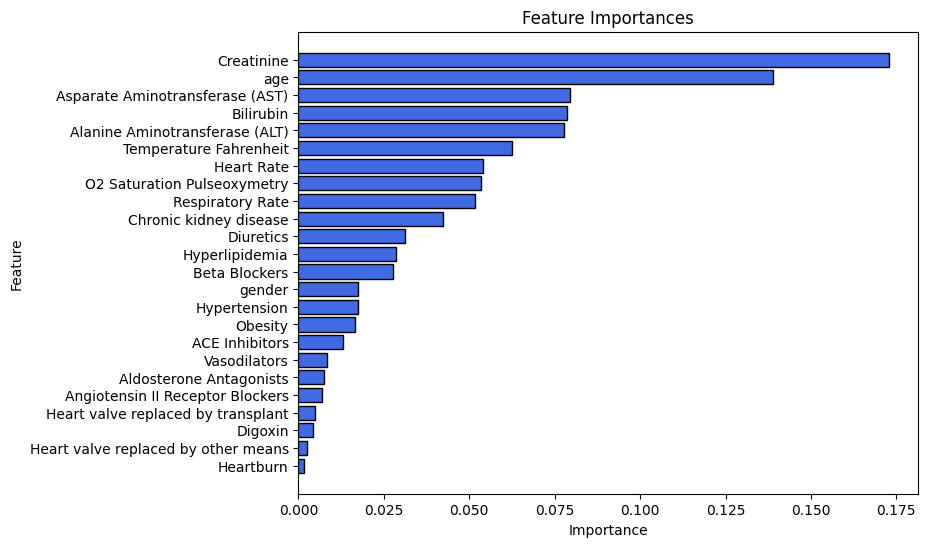

In [16]:
# Plotting the bar chart
plt.figure(figsize=(8, 6))
plt.barh(final_result['Feature'], final_result['Importance'], color = 'royalblue', edgecolor = 'black')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

### Run Same Model Based On Age and Gender

In [17]:
gender_metrics = {}

for i in range(0, 2):
    if i == 0:
        print("\nGender: Female")
    else:
        print("\nGender: Male")
    print("==================")
    
    # Create a mask for the current gender
    mask = X_test['gender'] == i
    
    # Filter X and y based on the gender mask
    X_test_gender = X_test[mask]
    y_test_gender = y_test[mask]
    
    # Get predictions for evaluation
    y_pred_prob = best_model.predict_proba(X_test_gender)[:, 1]
    y_pred = best_model.predict(X_test_gender)

    # Calculate evaluation metrics
    auc = roc_auc_score(y_test_gender, y_pred_prob)
    accuracy = accuracy_score(y_test_gender, y_pred)
    precision = precision_score(y_test_gender, y_pred)
    recall = recall_score(y_test_gender, y_pred)
    f1 = f1_score(y_test_gender, y_pred)

    gender_metrics[i] = [auc, accuracy, precision, recall, f1]

    print(f"Evaluation Results:\nAUC: {auc}\nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}")


Gender: Female
Evaluation Results:
AUC: 0.8628383396600099
Accuracy: 0.8
Precision: 0.8045454545454546
Recall: 0.6061643835616438
F1 Score: 0.69140625

Gender: Male
Evaluation Results:
AUC: 0.8574991120056831
Accuracy: 0.7843551797040169
Precision: 0.7052980132450332
Recall: 0.649390243902439
F1 Score: 0.6761904761904762


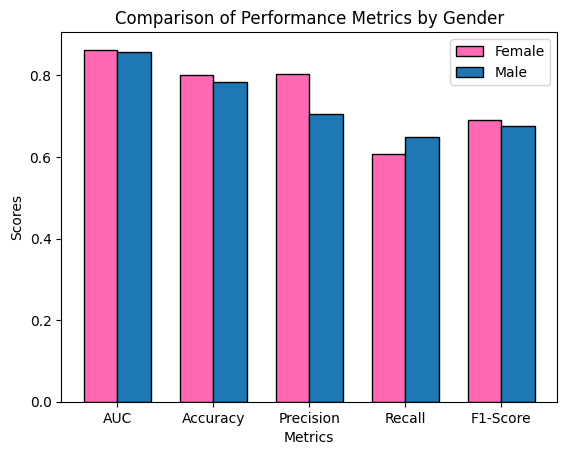

In [18]:
# Performance metrics for each gender
metrics = ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score']

# Bar plot for comparison
x = np.arange(len(metrics))
width = 0.35  # Bar width

fig, ax = plt.subplots()
ax.bar(x - width/2, gender_metrics[0], width, label = 'Female', color = 'hotpink', edgecolor = 'black')
ax.bar(x + width/2, gender_metrics[1], width, label = 'Male', edgecolor = 'black')

# Add labels and title
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Performance Metrics by Gender')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.show()

In [19]:
print(f"Min age: {X_test['age'].min()}, Max age: {X_test['age'].max()}")

Min age: 19, Max age: 98


In [20]:
age_ranges = [(19, 40), (40, 60), (60, 98)]
age_metrics = {}

for age_range in age_ranges:
    print(f"\nAge Range: {age_range[0]} to {age_range[1]}")
    print("=======================")
    
    # Create a mask for the current age range
    mask = (X_test['age'] >= age_range[0]) & (X_test['age'] < age_range[1])
    
    # Filter X and y based on the age mask
    X_test_age = X_test[mask]
    y_test_age = y_test[mask]
    
    # Get predictions for evaluation
    y_pred_prob = best_model.predict_proba(X_test_age)[:, 1]
    y_pred = best_model.predict(X_test_age)

    # Calculate evaluation metrics
    auc = roc_auc_score(y_test_age, y_pred_prob)
    accuracy = accuracy_score(y_test_age, y_pred)
    precision = precision_score(y_test_age, y_pred)
    recall = recall_score(y_test_age, y_pred)
    f1 = f1_score(y_test_age, y_pred)

    age_metrics[str(age_range)] = [auc, accuracy, precision, recall, f1]

    # Print results for the current age range
    print(f"Evaluation Results:\nAUC: {auc}\nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}\n")


Age Range: 19 to 40
Evaluation Results:
AUC: 0.9147267206477733
Accuracy: 0.9024390243902439
Precision: 0.8181818181818182
Recall: 0.47368421052631576
F1 Score: 0.6


Age Range: 40 to 60
Evaluation Results:
AUC: 0.8680816298150467
Accuracy: 0.8375
Precision: 0.7457627118644068
Recall: 0.46808510638297873
F1 Score: 0.5751633986928104


Age Range: 60 to 98
Evaluation Results:
AUC: 0.8362164662349676
Accuracy: 0.7646573080099092
Precision: 0.7450110864745011
Recall: 0.6640316205533597
F1 Score: 0.7021943573667712



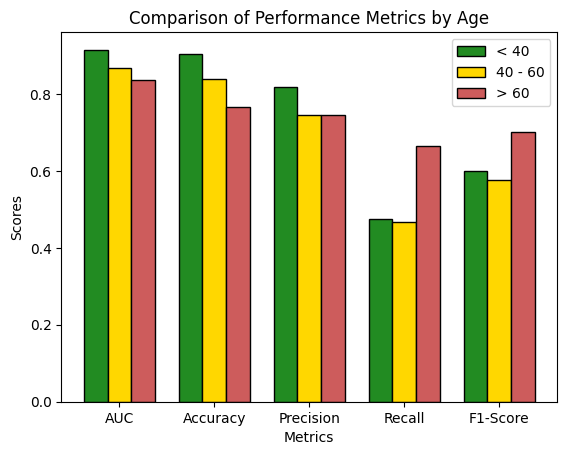

In [21]:
# Performance metrics for each gender
metrics = ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score']

# Bar plot for comparison
x = np.arange(len(metrics))
width = 0.25  # Bar width

fig, ax = plt.subplots()
ax.bar(x - width, age_metrics[str(age_ranges[0])], width, label = '< 40', color = 'forestgreen', edgecolor = 'black')
ax.bar(x, age_metrics[str(age_ranges[1])], width, label = '40 - 60', color = 'gold', edgecolor = 'black')
ax.bar(x + width, age_metrics[str(age_ranges[2])], width, label = '> 60', color = 'indianred', edgecolor = 'black')

# Add labels and title
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Performance Metrics by Age')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.show()

### SHAP Visualisation

In [22]:
# Initialize the SHAP explainer
explainer = shap.TreeExplainer(best_model)

# Compute SHAP values (for a sample of data)
shap_values = explainer.shap_values(X_train)

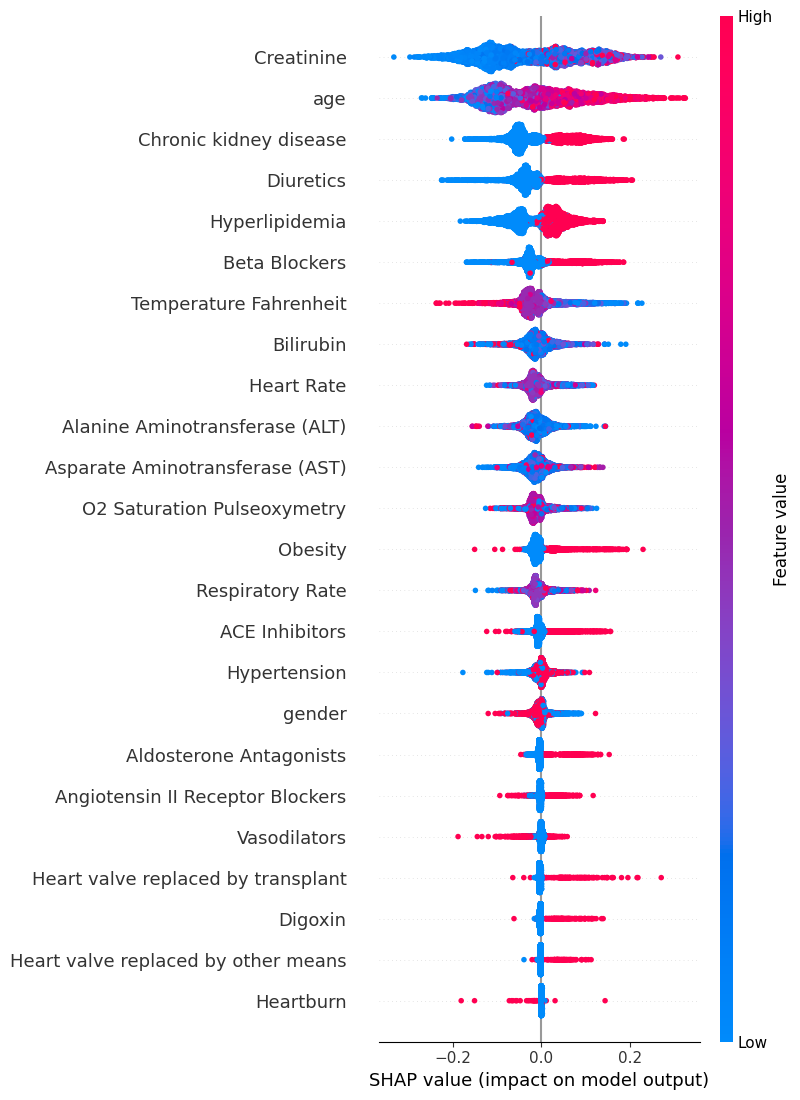

In [23]:
# Summary plot for feature importance (global interpretation)
shap.summary_plot(shap_values[:, :, 1], X_train, max_display = X_train.shape[1])